# Datagnosis Tutorial 03 - a real tabular example

*If you prefer, this tutorial is also available on [google colab](https://colab.research.google.com/drive/1oh98oMY2lywN8nvBnnCTVKCMuFqaL15n?usp=sharing).*

In this tutorial we will use "hardness characterization method" plugins to calculate the hardness scores for a real dataset. We will also plot these values and extract some data points based on these scores. For this tutorial we will be using a real COVID19 dataset from brazil (for reference see [here](https://github.com/vanderschaarlab/Datagnosis/data/Brazil_covis19/Brazil_covid19_data.md) for more info.)

OK, Lets start!

As with the other tutorials, first we import our logger from datagnosis and set the logging level at "INFO". If something goes wrong and you want to see more detailed logs, you can change the logging level to "DEBUG" or, conversely, if you don't want to see any logs you can remove them with log.remove().

In [1]:
import sys
from pathlib import Path

import datagnosis.logger as log
log.add(sink=sys.stderr, level="INFO")

Load the Brazil COVID19 dataset

In [2]:
import pandas as pd

# Get path to brazil covid19 data
root = next((parent for parent in Path.cwd().parents if parent.name == "datagnosis"), None)
data_path = root / Path("data/Brazil_covid19/Brazil_covid19.csv")
df = pd.read_csv(data_path)
X = None


Do some pre-processing on the data, such as setting the data up as a classification problem, by fixing a time horizon to the survival analysis problem.

In [3]:
if X is None: # Skips the preprocessing if X is already loaded
    time_horizon = 14

    df.loc[(df["Days_hospital_to_outcome"] <= time_horizon) & (df["is_dead"] == 1), f"is_dead_at_time_horizon={time_horizon}"] = 1
    df.loc[(df["Days_hospital_to_outcome"] > time_horizon), f"is_dead_at_time_horizon={time_horizon}"] = 0
    df.loc[(df["is_dead"] == 0), f"is_dead_at_time_horizon={time_horizon}"] = 0
    df[f"is_dead_at_time_horizon={time_horizon}"] = df[f"is_dead_at_time_horizon={time_horizon}"].astype(int)

    # drop survival columns as they are not needed for a classification problem
    df.drop(columns=["is_dead", "Days_hospital_to_outcome"], inplace=True)

    y = df[f"is_dead_at_time_horizon={time_horizon}"]
    X = df.drop(columns=[f"is_dead_at_time_horizon={time_horizon}"])
    
display(X.info())
display(X.describe())
display(X.head())
display(y.head())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6882 entries, 0 to 6881
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Age                     6882 non-null   int64
 1   Sex                     6882 non-null   int64
 2   Ethnicity               6882 non-null   int64
 3   Region                  6882 non-null   int64
 4   Fever                   6882 non-null   int64
 5   Cough                   6882 non-null   int64
 6   Sore_throat             6882 non-null   int64
 7   Shortness_of_breath     6882 non-null   int64
 8   Respiratory_discomfort  6882 non-null   int64
 9   SPO2                    6882 non-null   int64
 10  Dihareea                6882 non-null   int64
 11  Vomitting               6882 non-null   int64
 12  Cardiovascular          6882 non-null   int64
 13  Asthma                  6882 non-null   int64
 14  Diabetis                6882 non-null   int64
 15  Pulmonary            

None

,Age,Sex,Ethnicity,Region,Fever,Cough,Sore_throat,Shortness_of_breath,Respiratory_discomfort,SPO2,...,Vomitting,Cardiovascular,Asthma,Diabetis,Pulmonary,Immunosuppresion,Obesity,Liver,Neurologic,Renal
count,6882.00000,6882.000000,6882.000000,6882.000000,6882.000000,6882.000000,6882.000000,6882.000000,6882.000000,6882.000000,...,6882.000000,6882.000000,6882.000000,6882.000000,6882.000000,6882.000000,6882.000000,6882.000000,6882.000000,6882.000000
mean,58.77027,0.582244,0.785527,3.418483,0.801656,0.828393,0.249927,0.770561,0.677710,0.639785,...,0.086312,0.347283,0.038361,0.262714,0.054054,0.043301,0.046207,0.011915,0.044464,0.054490
std,18.09048,0.493225,0.661548,1.038621,0.398781,0.377066,0.433002,0.420503,0.467387,0.480098,...,0.280845,0.476141,0.192080,0.440140,0.226141,0.203549,0.209949,0.108512,0.206138,0.226998
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,46.00000,0.000000,0.000000,3.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,60.00000,1.000000,1.000000,4.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,72.00000,1.000000,1.000000,4.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,104.00000,1.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,Age,Sex,Ethnicity,Region,Fever,Cough,Sore_throat,Shortness_of_breath,Respiratory_discomfort,SPO2,...,Vomitting,Cardiovascular,Asthma,Diabetis,Pulmonary,Immunosuppresion,Obesity,Liver,Neurologic,Renal
0,1,0,0,2,1,1,0,1,1,1,...,0,0,1,0,0,0,0,0,0,0
1,75,0,0,2,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,61,1,0,2,1,1,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0
3,81,1,0,2,1,1,0,1,1,1,...,0,1,0,1,0,0,0,0,0,0
4,86,0,0,2,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


0    0
1    0
2    1
3    1
4    1
Name: is_dead_at_time_horizon=14, dtype: int64

The next key step is to then pass the data to the DataHandler object provided by Datagnosis. This is done by passing the features and the labels separately. The features can be a `pandas.DataFrame`, `numpy.ndarray` or `torch.Tensor`. The labels can be `pandas.series`, `numpy.ndarray` or `torch.Tensor`.

In [4]:
from datagnosis.plugins.core.datahandler import DataHandler

datahander = DataHandler(X, y, batch_size=32)

Now we define some values which we will pass to the plugin

In [5]:
from datagnosis.plugins.core.models.simple_mlp import SimpleMLP
import torch
import torch.nn as nn

model = SimpleMLP(input_dim=X.shape[1], output_dim=len(y.unique()))
display(model)
# creating our optimizer and loss function object
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

SimpleMLP(
  (input_layer): Linear(in_features=21, out_features=128, bias=True)
  (hidden_layer1): Linear(in_features=128, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
)

Import the `Plugins` object from Datagnosis. Then by calling `list()` on the we can see all the available plugins that we can use.

In [6]:
from datagnosis.plugins import Plugins

plugins = Plugins().list()
print(plugins)


['grand', 'confident_learning', 'aum', 'vog', 'el2n', 'allsh', 'data_iq', 'large_loss', 'data_maps', 'prototypicality', 'forgetting', 'conf_agree']


Now we can call `get()` to load up a specific plugin from the list and then we call `fit()`  to fit the plugin.

In [11]:
hcm = Plugins().get(
    "conf_agree",
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    lr=learning_rate,
    epochs=10,
    num_classes=2,
    logging_interval=1,
)
hcm.fit(
    datahandler=datahander,
    use_caches_if_exist=True,
)

[2023-07-24T11:52:59.188410+0100][14887][INFO] Fitting conf_agree
[2023-07-24T11:53:00.023861+0100][14887][INFO] Epoch 1/10: Loss=0.6416
[2023-07-24T11:53:00.342516+0100][14887][INFO] Epoch 2/10: Loss=0.5682
[2023-07-24T11:53:00.661252+0100][14887][INFO] Epoch 3/10: Loss=0.5659
[2023-07-24T11:53:00.983678+0100][14887][INFO] Epoch 4/10: Loss=0.5587
[2023-07-24T11:53:01.317816+0100][14887][INFO] Epoch 5/10: Loss=0.5663
[2023-07-24T11:53:01.648010+0100][14887][INFO] Epoch 6/10: Loss=0.5599
[2023-07-24T11:53:01.965939+0100][14887][INFO] Epoch 7/10: Loss=0.5512
[2023-07-24T11:53:02.274871+0100][14887][INFO] Epoch 8/10: Loss=0.5563
[2023-07-24T11:53:02.601021+0100][14887][INFO] Epoch 9/10: Loss=0.5517
[2023-07-24T11:53:02.908684+0100][14887][INFO] Epoch 10/10: Loss=0.5504


To understand the scores, we can call `score_description()`, if you need a refresher as to what the score does.

In [12]:
print("description: ", hcm.score_description())
print("hard direction: ", hcm.hard_direction())

description:  Models should be confident on examples that are well-represented. Based
on an ensemble of models, this metric ranks examples by the mean confidence in the models'
predictions. Therefore, examples with low confidence are considered hard to classify, because
ensemble of models are not collectively confident about how to classify the data point.

hard direction:  low


Now we understand the scores, lets plot them

[2023-07-24T11:53:08.269498+0100][14887][INFO] Plotting conf_agree scores


None


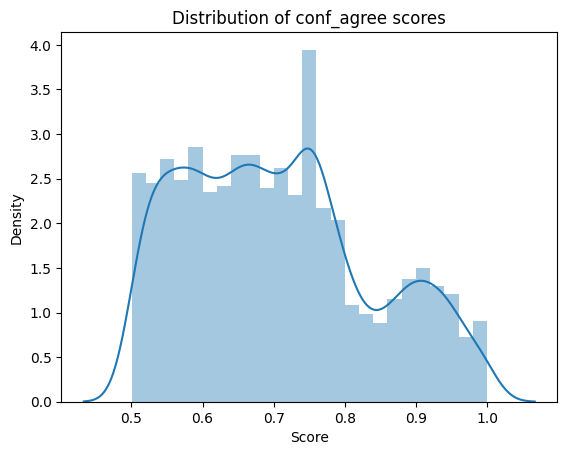

In [13]:
print(hcm.score_names)
hcm.plot_scores(axis=1, plot_type="dist")

And lets pick out some specific datapoints to examine. To start we can examine the hardest to classify points.

In [14]:
import pandas as pd

hardest_5 = hcm.extract_datapoints(method="top_n", n=20, sort_by_index=False)

n_cols = len(X.columns)
display(pd.DataFrame(
    data={
        "indices":hardest_5[0][2],
        "labels": hardest_5[0][1],
        "scores": hardest_5[1],
        **{
            f"{X.columns[i]}": hardest_5[0][0].transpose(0,1)[i] for i in range(n_cols)
        },
    }
))

[2023-07-24T11:53:36.213448+0100][14887][WARNING] You have provided a `threshold`, this is only used with the `threshold` method, so will be ignored.


,indices,labels,scores,Age,Sex,Ethnicity,Region,Fever,Cough,Sore_throat,...,Vomitting,Cardiovascular,Asthma,Diabetis,Pulmonary,Immunosuppresion,Obesity,Liver,Neurologic,Renal
0,6586,1,0.500043,58.0,0.0,0.0,4.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4964,0,0.500124,71.0,0.0,1.0,4.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5522,1,0.500156,50.0,0.0,0.0,4.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4179,0,0.500192,45.0,1.0,1.0,4.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,3002,0,0.500261,64.0,1.0,0.0,4.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2757,1,0.500477,75.0,1.0,0.0,4.0,1.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
6,816,1,0.500617,37.0,0.0,1.0,4.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,5615,0,0.500691,46.0,1.0,1.0,4.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4563,1,0.500706,46.0,1.0,1.0,4.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
9,6671,0,0.500730,30.0,0.0,1.0,4.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
